In [1]:
import pandas as pd
import xarray as xr
import rasterio as rio
import geopandas as gpd
import rasterstats as rstats
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import netCDF4


Here we are trying to create a script that will take bathymetric data from : https://download.gebco.net and create a bathymetric map to be used in the study of offshore eolian parcs. 

In a first time we will extract the data from Netcdf and plot the map. This operation require the netCDF4 library.

Text(0.5, 1.0, 'Bathymétrie de la zone')

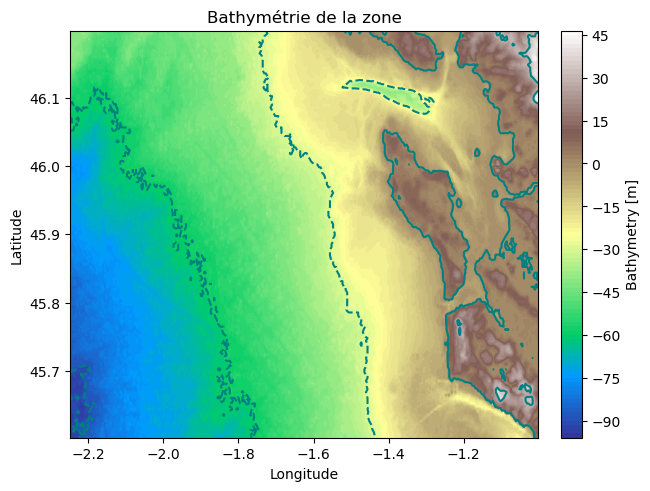

In [2]:
#Création de dataset à partir de fichiers téléchargés. Ici pour l'île d'Oléron, la Méditérannée et la Bretagne
nc1 = netCDF4.Dataset('C:/Users/Jordan/Documents/Bluegreen/GEBCO_07_Dec_2023_7cfdb93e4c12/gebco_2023_n46.2_s45.6_w-2.25_e-1.0.nc')#Oleron
#nc2 = netCDF4.Dataset('C:/Users/Jordan/Documents/Bluegreen/GEBCO_27_Nov_2023_f392ab3e28c0/gebco_2023_n43.5017_s42.3564_w5.5385_e7.0958.nc')#Mediterrane
#nc3 = netCDF4.Dataset('C:/Users/Jordan/Documents/Bluegreen/GEBCO_27_Nov_2023_f392ab3e28c0/gebco_2023_n48.5932_s47.8571_w-5.1711_e-4.4158.nc')#Brest

#nc1.variables

# Extraction des variable (Profondeur et coordonnées)
Blat1 = nc1.variables['lat'][:].data
Blon1 = nc1.variables['lon'][:].data
Bdepth1 = nc1.variables['elevation'][:].data
"""
Blat2 = nc2.variables['lat'][:].data
Blon2 = nc2.variables['lon'][:].data
Bdepth2 = nc2.variables['elevation'][:].data

Blat3 = nc3.variables['lat'][:].data
Blon3 = nc3.variables['lon'][:].data
Bdepth3 = nc3.variables['elevation'][:].data
"""

#Fond de carte pour l'île d'Oléron
lat1,lon1 = np.meshgrid (Blat1,Blon1)
fig,ax1 = plt.subplots(layout='constrained')
CF1=ax1.contourf(Blon1,Blat1,Bdepth1,levels=100,cmap='terrain')
CS1=ax1.contour(Blon1,Blat1,Bdepth1,levels=4,colors='Teal')
cbat =fig.colorbar(CF1)
cbat.set_label('Bathymetry [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax1.set_title('Bathymétrie de la zone')

In [3]:
nc1.variables['lat']

<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
    sdn_parameter_urn: SDN:P01::ALATZZ01
    sdn_parameter_name: Latitude north
    sdn_uom_urn: SDN:P06::DEGN
    sdn_uom_name: Degrees north
unlimited dimensions: 
current shape = (144,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
"""
#Fond de carte pour la Mediterranée
fig,ax2 = plt.subplots(layout='constrained')
lat2,lon2 = np.meshgrid (Blat2,Blon2)
CF2=ax2.contourf(Blon2,Blat2,Bdepth2,levels=100,cmap='terrain')
CS2=ax2.contour(Blon2,Blat2,Bdepth2,levels=1,colors='olive')
plt.axis('off')
plt.savefig('bathy_map_MED.png') 
#cbat =fig.colorbar(CF2)

#Fond de carte pour la Bretagne
fig,ax3= plt.subplots(layout='constrained')
lat3,lon3 = np.meshgrid (Blat3,Blon3)
CF2=ax3.contourf(Blon3,Blat3,Bdepth3,levels=100,cmap='terrain')
CS2=ax3.contour(Blon3,Blat3,Bdepth3,levels=1,colors='olive')
#cbat =fig.colorbar(CF3)
plt.axis('off')
plt.savefig('bathy_map_BRT.png') 
"""

"\n#Fond de carte pour la Mediterranée\nfig,ax2 = plt.subplots(layout='constrained')\nlat2,lon2 = np.meshgrid (Blat2,Blon2)\nCF2=ax2.contourf(Blon2,Blat2,Bdepth2,levels=100,cmap='terrain')\nCS2=ax2.contour(Blon2,Blat2,Bdepth2,levels=1,colors='olive')\nplt.axis('off')\nplt.savefig('bathy_map_MED.png') \n#cbat =fig.colorbar(CF2)\n\n#Fond de carte pour la Bretagne\nfig,ax3= plt.subplots(layout='constrained')\nlat3,lon3 = np.meshgrid (Blat3,Blon3)\nCF2=ax3.contourf(Blon3,Blat3,Bdepth3,levels=100,cmap='terrain')\nCS2=ax3.contour(Blon3,Blat3,Bdepth3,levels=1,colors='olive')\n#cbat =fig.colorbar(CF3)\nplt.axis('off')\nplt.savefig('bathy_map_BRT.png') \n"

Since the bathymetric data have been extratced into xarrays, it's pretty simple to extract the minimu, maximum and mean depth

In [5]:
print('Minimum pour Oléron=',Bdepth1.min(),'m') 
print('Maximum pour Oléron=',Bdepth1.max(),'m')
print('Moyenne pour Oléron=',Bdepth1.mean(),'m')

#print('Minimum pour la Méditerranée=',Bdepth2.min(),'m') 
#print('Maximum pour la Méditerranée=',Bdepth2.max(),'m')
#print('Moyenne pour la Méditerranée=',Bdepth2.mean(),'m')

#print('Minimum pour la Bretagne=',Bdepth3.min(),'m') 
#print('Maximum pour la Bretagne=',Bdepth3.max(),'m')
#print('Moyenne pour la Bretagne=',Bdepth3.mean(),'m')

Minimum pour Oléron= -95 m
Maximum pour Oléron= 46 m
Moyenne pour Oléron= -33.32560185185185 m


However those statistics, especially the mean, are calculated for all the downloaded data. And here it means it also that in the calculation of the avrage depth above wather shore are taken in account. So we decided to write a small function to calculate the mean depth for all depths bellow 0m.

In [6]:
def average_SL(Blat,Blon,Bdepth):
    num=0
    M=0
    for i in range(len(Blat)):
        for j in range(len(Blon)):

            a=Bdepth[i,j]
            if a<0 :
                    num+=a
                    M+=1
                    avg=num/M
    return avg
print('Moyenne sous le niveau de la mer pour Oléron=',average_SL(Blat1,Blon1,Bdepth1),"m")
#print('Moyenne sous le niveau de la mer pour La Mediterranée=',average_SL(Blat2,Blon2,Bdepth2),"m")
#print('Moyenne sous le niveau de la mer pour La Bretagne=',average_SL(Blat3,Blon3,Bdepth3),"m")

Moyenne sous le niveau de la mer pour Oléron= -41.034597325571816 m


In this next part we will extract and plot the Shapefiles of relevant offshore eolian parcs. This operation requires the geopandas library, wich itself requires the Fiona library to be installed. 

We have met some difficulties installing and running both those libraries on the base environement. We have created a brand new one to circumvent those issues.

In [7]:
shape1 = gpd.read_file("C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc1_epsg2154_S.shp")
shape2 = gpd.read_file("C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc2_epsg2154_S.shp")

shape1.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Géométries des Parcs Eoliens')

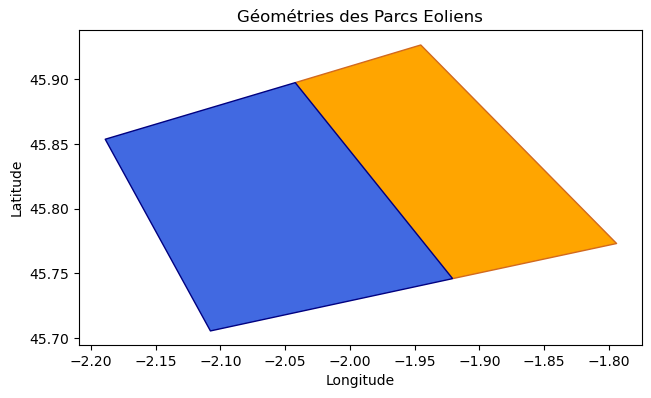

In [8]:
projo1= shape1.to_crs('epsg:4326')
projo2= shape2.to_crs('epsg:4326')

fig,ax1 = plt.subplots(layout='constrained')
projo1.plot(ax=ax1,color='orange', edgecolor='chocolate',)
projo2.plot(ax=ax1,color='royalblue', edgecolor='navy')
ax1.set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax1.set_title('Géométries des Parcs Eoliens')

Text(0.5, 1.0, 'Bathymétrie et Position de Parcs Eoliens')

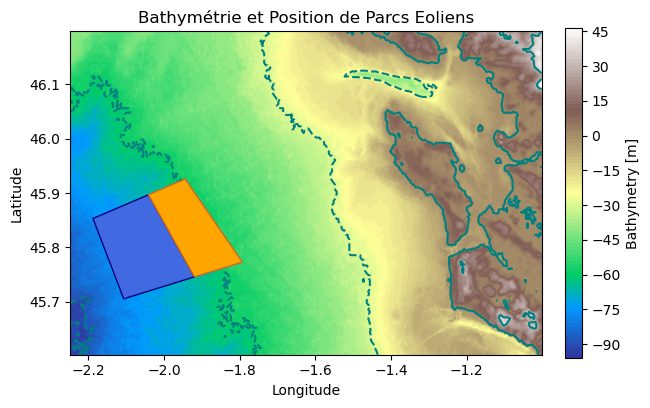

In [9]:
#Fond de carte pour l'île d'Oléron
lat1,lon1 = np.meshgrid (Blat1,Blon1)
fig,ax1 = plt.subplots(layout='constrained')
projo1.plot(ax=ax1,color='orange', edgecolor='chocolate',zorder=10)
projo2.plot(ax=ax1,color='royalblue', edgecolor='navy',zorder=9)
CF1=ax1.contourf(Blon1,Blat1,Bdepth1,levels=100,cmap='terrain',zorder=1)
CS1=ax1.contour(Blon1,Blat1,Bdepth1,levels=4,colors='teal',zorder=2)
cbat =fig.colorbar(CF1,shrink=0.7)
cbat.set_label('Bathymetry [m]')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax1.set_title('Bathymétrie et Position de Parcs Eoliens')

In [10]:
shape1 = gpd.read_file("C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc1_epsg2154_S.shp")
shape2 = gpd.read_file("C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc2_epsg2154_S.shp")
projo1= shape1.to_crs('epsg:4326')
projo2= shape2.to_crs('epsg:4326')

# Merge/Combine multiple shapefiles into one
double = gpd.pd.concat([projo1, projo2])
 
#Export merged geodataframe into shapefile
#north_south_carolina.to_file("north_south_carolina.shp")
double

,aire,Nom,geometry
0,"180,0655826866",Zone retenue - premier parc,"POLYGON ((-1.92113 45.74639, -2.04262 45.89768..."
0,"252,467539772964",Zone retenue - deuxième parc,"POLYGON ((-1.92113 45.74639, -2.10807 45.70603..."



To facilitate the utilization of the geopandas plot function we will merge the two shapefiles. (this is mostly to have a cleaner legend)

Text(0.5, 1.0, 'Bathymétrie et Position de Parcs Eoliens')

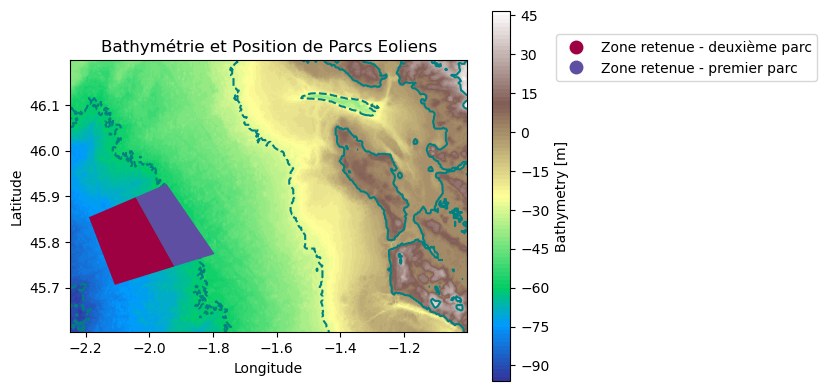

In [11]:
Blat1 = nc1.variables['lat'][:].data
Blon1 = nc1.variables['lon'][:].data
Bdepth1 = nc1.variables['elevation'][:].data

lat1,lon1 = np.meshgrid (Blat1,Blon1)
fig,ax = plt.subplots()

double.plot(ax=ax,column='Nom',cmap='Spectral',zorder=9,legend=True, legend_kwds={'bbox_to_anchor': (1.9, 1.12)})
       
CF1=ax.contourf(Blon1,Blat1,Bdepth1,levels=100,cmap='terrain',zorder=1)
CS1=ax.contour(Blon1,Blat1,Bdepth1,levels=4,colors='teal',zorder=2)
cbat =fig.colorbar(CF1)
cbat.set_label('Bathymetry [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_title('Bathymétrie et Position de Parcs Eoliens')

In this next part of the script we are trying to extract the bathymetric data for the area occupied by the two eaolian parcs.

Thankfully the rasterstats extension is posess a function called zonal_stats that calculate the relevant statictic of a given geometry (here the polygon inside the shape file)

we can use it as follow :

In [12]:
# load and read shp-file with geopandas
shp_fo1 = r'C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc1_epsg2154_S.shp'
shp_fo2 = r'C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc2_epsg2154_S.shp'

shp_df = gpd.read_file(shp_fo2)
shp_df = shp_df.to_crs('epsg:4326')

# load and read netCDF-file to dataset and get datarray for variable
nc_fo = r'C:/Users/Jordan/Documents/Bluegreen/GEBCO_07_Dec_2023_7cfdb93e4c12/gebco_2023_n46.2_s45.6_w-2.25_e-1.0.nc'
nc_ds = xr.open_dataset(nc_fo)
nc_var = nc_ds['elevation']

# get affine of nc-file with rasterio
affine = rio.open(nc_fo).transform
nc_arr = nc_var
nc_arr_vals = nc_arr.values


print(rstats.zonal_stats(shp_df.geometry, nc_arr_vals, affine=affine, stats="mean min max"))
print('')

[{'min': -70.0, 'max': -43.0, 'mean': -58.36838978015449}]



F:\Anaconda\envs\Geo\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Then it's a simple question of putting the pervious calculation in the form of function that will take as argument the paths of the relevant files.

In [13]:
def stat(file_shape,file_dpth):

    shp_df = gpd.read_file(file_shape)
    shp_df = shp_df.to_crs('epsg:4326')

    nc_ds = xr.open_dataset(file_dpth)
    nc_var = nc_ds['elevation']

    affine = rio.open(nc_fo).transform
    nc_arr = nc_var
    nc_arr_vals = nc_arr.values

    return(rstats.zonal_stats(shp_df.geometry, nc_arr_vals, affine=affine, stats="mean min max"))

stat(shp_fo1,nc_fo)


[{'min': -67.0, 'max': -41.0, 'mean': -52.97185430463576}]

Next we will creat a function to plot bathymetric data and shapefiles like previously. 

To facilitate the utilization of the geopandas plot function we will merge the two shapefiles. (this is mostly to have a cleaner legend)

In [14]:
shp_df1 = gpd.read_file(shp_fo1)
shp_df1 = shp_df1.to_crs('epsg:4326')

shp_df2 = gpd.read_file(shp_fo2)
shp_df2 = shp_df2.to_crs('epsg:4326')

# Merge/Combine multiple shapefiles into one
double = gpd.pd.concat([shp_df1, shp_df2])
 
#Export merged geodataframe into shapefile
#north_south_carolina.to_file("north_south_carolina.shp")
double

,aire,Nom,geometry
0,"180,0655826866",Zone retenue - premier parc,"POLYGON ((-1.92113 45.74639, -2.04262 45.89768..."
0,"252,467539772964",Zone retenue - deuxième parc,"POLYGON ((-1.92113 45.74639, -2.10807 45.70603..."


Text(0.5, 1.0, 'Bathymétrie et Position de Parcs Eoliens')

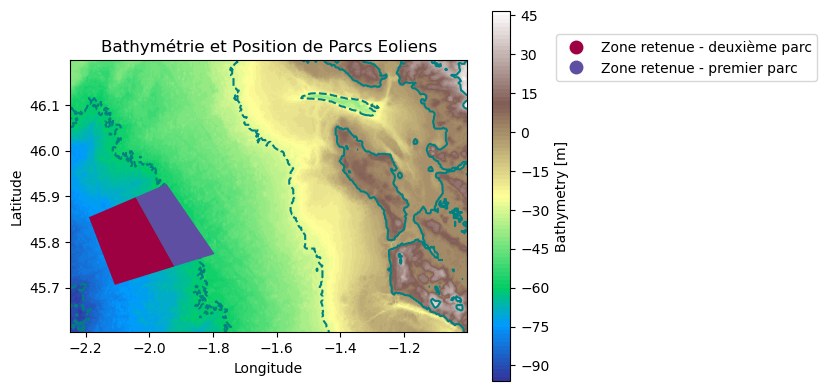

In [15]:
nc1 = netCDF4.Dataset(nc_fo)
Blat1 = nc1.variables['lat'][:].data
Blon1 = nc1.variables['lon'][:].data
Bdepth1 = nc1.variables['elevation'][:].data

lat1,lon1 = np.meshgrid (Blat1,Blon1)
fig,ax = plt.subplots()

double.plot(ax=ax,column='Nom',cmap='Spectral',zorder=9,legend=True, legend_kwds={'bbox_to_anchor': (1.9, 1.12)})
       
CF1=ax.contourf(Blon1,Blat1,Bdepth1,levels=100,cmap='terrain',zorder=1)
CS1=ax.contour(Blon1,Blat1,Bdepth1,levels=4,colors='teal',zorder=2)
cbat =fig.colorbar(CF1)
cbat.set_label('Bathymetry [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_title('Bathymétrie et Position de Parcs Eoliens')


The main issue is that while the previous codes have been effective in a predetermine case, especially one with 2 shapefiles, most other case will likely only have one shapefile.
However we will define our function so it can function in both those cases.

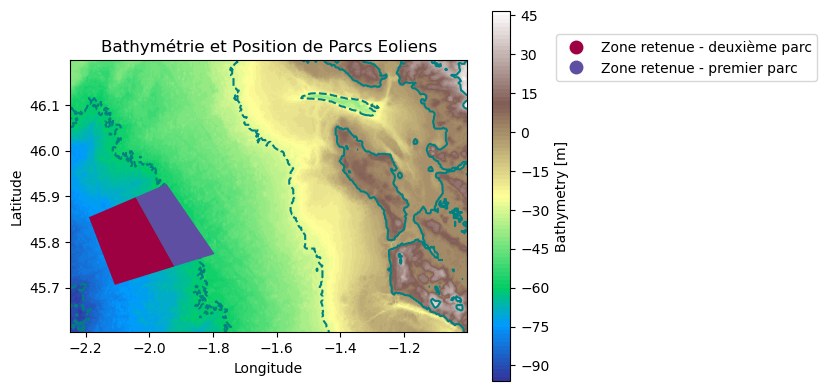

In [16]:
nc_fo = r'C:/Users/Jordan/Documents/Bluegreen/GEBCO_07_Dec_2023_7cfdb93e4c12/gebco_2023_n46.2_s45.6_w-2.25_e-1.0.nc'
shp_fo1 = r'C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc1_epsg2154_S.shp'
shp_fo2 = r'C:/Users/Jordan/Documents/Bluegreen/shape/N_Eolien_AO7_Sud_Atlantique_epsg2154_092022_shape/N_Eolien_AO7_Sud_Atlantique_Parc2_epsg2154_S.shp'


def stat(file_shape,file_dpth):

    shp_df = gpd.read_file(file_shape)
    shp_df = shp_df.to_crs('epsg:4326')

    nc_ds = xr.open_dataset(file_dpth)
    nc_var = nc_ds['elevation']

    affine = rio.open(nc_fo).transform
    nc_arr = nc_var
    nc_arr_vals = nc_arr.values

    S=rstats.zonal_stats(shp_df.geometry, nc_arr_vals, affine=affine, stats="mean min max")
    return(S[0])

def map(shape1,bathy,shape2=False):
    nc1 = netCDF4.Dataset(bathy)
    Blat1 = nc1.variables['lat'][:].data
    Blon1 = nc1.variables['lon'][:].data
    Bdepth1 = nc1.variables['elevation'][:].data
    shp_df1 = gpd.read_file(shape1)
    shp_df1 = shp_df1.to_crs('epsg:4326')

    lat1,lon1 = np.meshgrid (Blat1,Blon1)
    fig,ax = plt.subplots()
    
    if shape2 is False:
        shp_df1.plot(ax=ax,column='Nom',cmap="Spectral",zorder=9,legend=True, legend_kwds={'bbox_to_anchor': (1.9, 1.12)})
       
        CF1=ax.contourf(Blon1,Blat1,Bdepth1,levels=100,cmap='terrain',zorder=1)
        CS1=ax.contour(Blon1,Blat1,Bdepth1,levels=4,colors='teal',zorder=2)
        cbat =fig.colorbar(CF1)
        cbat.set_label('Bathymetry [m]')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')


    else:
        
        shp_df2 = gpd.read_file(shape2)
        shp_df2 = shp_df2.to_crs('epsg:4326')
        
        double = gpd.pd.concat([shp_df1, shp_df2])
        
        double.plot(ax=ax,column='Nom',cmap="Spectral",zorder=9,legend=True, legend_kwds={'bbox_to_anchor': (1.9, 1.12)})
       
        CF1=ax.contourf(Blon1,Blat1,Bdepth1,levels=100,cmap='terrain',zorder=1)
        CS1=ax.contour(Blon1,Blat1,Bdepth1,levels=4,colors='teal',zorder=2)
        cbat =fig.colorbar(CF1)
        cbat.set_label('Bathymetry [m]')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        ax.set_title('Bathymétrie et Position de Parcs Eoliens')
        
map(shp_fo1,nc_fo,shp_fo2)